In [1]:
%matplotlib notebook
#%matplotlib inline
# standard imports 
from __future__ import division 
from __future__ import print_function 
import matplotlib.pyplot as plt 
import numpy as np 
import os 
from glob import glob 

In [2]:
# imports for playing with fits files 
from sunpy.net import Fido, attrs
from datetime import datetime, timedelta
import astropy.units as u 
import sunpy.map as smap 
from astropy.coordinates import SkyCoord 
from scipy.interpolate import interp1d
from astropy.convolution import convolve, Box1DKernel
from datetime import datetime, timedelta
import matplotlib.dates as mdates 

In [3]:
from AIA_tools import * 

In [4]:
fits_files = {'171':glob("../data/June_2010_CME_burst/fitsFiles/171/*.fits"), 
              '193': glob("../data/June_2010_CME_burst/fitsFiles/193/*.fits"), 
              '211': glob("../data/June_2010_CME_burst/fitsFiles/211/*.fits"), 
              '304': glob("../data/June_2010_CME_burst/fitsFiles/304/*.fits"), 
              '335': glob("../data/June_2010_CME_burst/fitsFiles/335/*.fits")}

num_wavelengths = 5 
assert(len(fits_files['171'])==len(fits_files['193']))
assert(len(fits_files['193'])==len(fits_files['211']))
assert(len(fits_files['211'])==len(fits_files['304']))
assert(len(fits_files['304'])==len(fits_files['335']))
assert(len(fits_files['335'])==len(fits_files['171'])) 



** Create our maps, submaps, and tiny boxes for analysis ** 

In [5]:
data_maps = {'171':[], '193':[], '211':[], '304':[], '335':[]}
sub_maps = {'171':[], '193':[], '211':[], '304':[], '335':[]}
tiny_box = {'171':[], '193':[], '211':[], '304':[], '335':[]}

# submap coordinates in arcseconds 
sm_bl_x =700 
sm_bl_y = -700 
sm_tr_x = 1200 
sm_tr_y = -200 

# tiny box coordinates in arcseconds
dr = 15 
tb_bl_x = 1145 
tb_bl_y = -410
tb_tr_x = 1145+dr 
tb_tr_y = -410+dr 


for key in data_maps: 
    data_maps[key].append(smap.Map(fits_files[key][50]))
    sub_maps[key].append(analysis.makeSubmap(data_maps[key][0], sm_bl_x, sm_bl_y, sm_tr_x, sm_tr_y))
    tiny_box[key].append(analysis.makeSubmap(data_maps[key][0], tb_bl_x, tb_bl_y, tb_tr_x, tb_tr_y)) 
        

/usr/local/anaconda2/lib/python2.7/site-packages/sunpy/map/sources/sdo.py:48: SunpyDeprecationWarning: Use Matplotlib to load the colormaps
  self.plot_settings['cmap'] = cm.get_cmap(self._get_cmap_name())


** Let's see if we can replicate figure 2 from Ma et al. Paper before animating full time dependence ** 

<IPython.core.display.Javascript object>


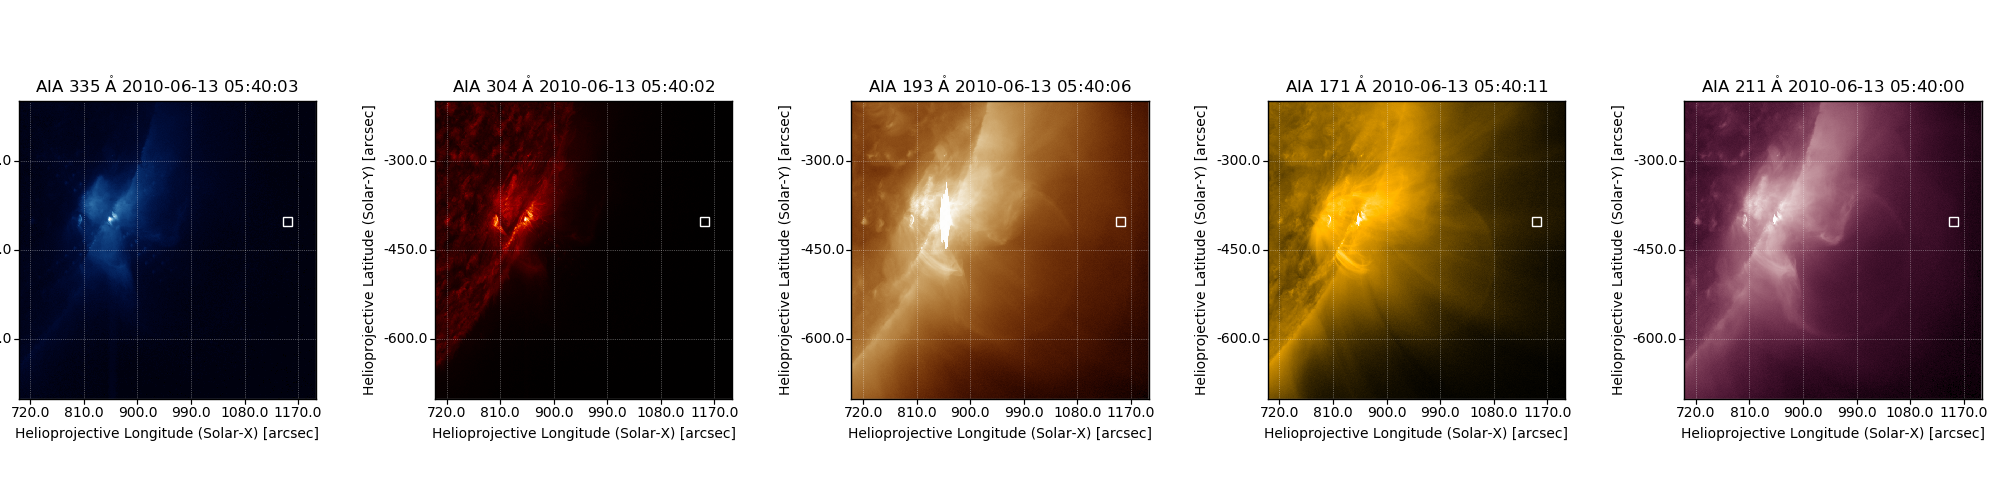

In [6]:
fig = plt.figure(figsize=(20, 5)) 
i = 1 
for key in sub_maps: 
    ax_i = plt.subplot(1, 5, i, projection = sub_maps[key][0])
    sub_maps[key][0].plot() 
    bl = SkyCoord(tb_bl_x*u.arcsec, tb_bl_y*u.arcsec,
                       frame=sub_maps[key][0].coordinate_frame) 
    sub_maps[key][0].draw_rectangle(bl, dr*u.arcsec, dr*u.arcsec)
    i+=1
    
plt.tight_layout() 
plt.subplots_adjust(left=None, bottom=None, right=None, top=None,
                wspace=0.4, hspace=None)

** Okay, I think this box looks good. ** 

In [7]:
intensities = {'171':[], '193':[], '211':[], '304':[], '335':[]}
times =  {'171':[], '193':[], '211':[], '304':[], '335':[]}

data_maps = {}
sub_maps = {}
tiny_box = {}

for i in range(len(fits_files['171'])): 
    print(i) 
    for key in intensities:
        data_maps[key] = smap.Map(fits_files[key][i])
        sub_maps[key] = analysis.makeSubmap(data_maps[key], sm_bl_x, sm_bl_y, sm_tr_x, sm_tr_y)
        tiny_box[key] = analysis.makeSubmap(data_maps[key], tb_bl_x, tb_bl_y, tb_tr_x, tb_tr_y)
        intensities[key].append(np.average(tiny_box[key].data)) 
        time = tiny_box[key].meta['date_obs'] 
        time = datetime.strptime(time, '%Y-%m-%dT%H:%M:%S.%f')
        times[key].append(time) 



0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


<IPython.core.display.Javascript object>


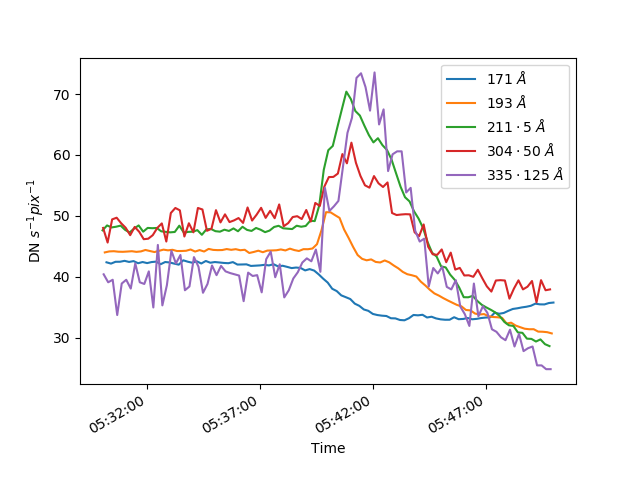

In [8]:
fig, ax = plt.subplots() 

ax.plot(times['171'], intensities['171'], label='$171$ $\AA$') 
ax.plot(times['193'], intensities['193'], label='$193$ $\AA$')
ax.plot(times['211'], 5*np.asarray(intensities['211']), label='$211 \cdot 5$ $\AA$')
ax.plot(times['304'], 50*np.asarray(intensities['304']), label='$304 \cdot 50$ $\AA$')
ax.plot(times['335'], 125*np.asarray(intensities['335']), label='$335 \cdot 125$ $\AA$') 


fig.autofmt_xdate()
myFmt = mdates.DateFormatter('%H:%M:%S')
ax.xaxis.set_major_formatter(myFmt)
ax.set_ylabel("DN $s^{-1} pix^{-1}$")
ax.set_xlabel("Time")
ax.legend() 


** Pickel the box intensity info so we can easily use it later ** 

In [9]:
import pickle

In [10]:
file_Name = "intensities_MaEtAl.pickle"
with open(file_Name,'wb') as f:
    pickle.dump(intensities, f)

file_Name = "times_MaEtAl.pickle"
with open(file_Name,'wb') as f: 
    pickle.dump(times, f)


file_Name = "boxInfo_MaEtAl.pickle"
with open(file_Name,'wb') as f:
    box_info = {'dr':dr, 'tb_bl_x':tb_bl_x, 'tb_bl_y':tb_bl_y} 
    pickle.dump(box_info, f) 




In [11]:
with open('intensities_MaEtAl.pickle','r') as f: 
    intensities = pickle.load(f)
print(intensities['171'][0])

with open('times_MaEtAl.pickle','r') as f: 
    times = pickle.load(f)
print(times['171'][0])

with open('boxInfo_MaEtAl.pickle', 'r') as f: 
    info = pickle.load(f) 
print(info) 

42.36641563471922
2010-06-13 05:30:11.110000
{'dr': 15, 'tb_bl_y': -410, 'tb_bl_x': 1145}


** Plot the relative intensities**

In [ ]:
fig, ax = plt.subplots() 
ax.plot(times, )